# Succesful multi-variate communication

This notebook shows how to "transfer" multiple variables across a wire in a wiring diagram. This is merely a work-around may not be nessesary in future versions of AlgebraicDynamics. Nonetheless, this approach works well and is easy to implement.

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [2]:
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  )
);

### Part 1 - Two boxes

Consider a system with two boxes communicating with each other. The purpose of the wires is to indicate there is a transfer of information. They tell us nothing of the quantity of information being transferred.

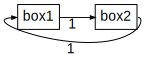

In [3]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [:1], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1], [:1]) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1)
    (box2,1) => (box1,1)
])

show_diagram(diagram)

In order to make the results intuitive, let us assume each box contains a spring-mass system. We can define the behavior of this system through a set coefficients. Let us also define the initial conditions for each state.

In [4]:
#- Coefficients
# Mass #1
k1 = 1;     
c1 = 1;

# Mass #2
k2 = 1; 
c2 = 4;

# Parameters for ODE Solver:
u_init = [1, 0, 1, 0];       # Initial conditions: [x1, v1, x2, v2]
t_span = (0, 20);            # Interval of solution

The boxes can communicate with each other by simply ignoring the output vector of the readout function. Instead, we can use the readout function to update an external variable that holds the current state of a box. Within the state function we access this variable and use it as the input for the relevant box.  

With this scheme we can circumvent the limitations the readout function by externalizing its purpose. We can use a simple wiring diagram and ascribe to it any equations we choose. The dimensions of the input vectors becomes irrelevant and can be as large as the external variable that stores them.

In [5]:
#- Readout functions: r(u)

# Vectors that store the current state of each box
s1 = zeros(2);
s2 = zeros(2);

function readout1(u) 
    global s1 = u;  # Store the current state
    return [0];     # Output a vector with a length equal to the number of box outputs
end

function readout2(u) 
    global s2 = u;
    return [0];    # The return value is not used. Only the type matters and the length of the vector.
end

#- Input Functions: 
common_term(u, x) = k2*(x[1] - u[1]) + c2*(x[2] - u[2]);     
                        
function equation1(u, x, p, t) 
    x = s2;   # Overwrite the input with stored state
    return [ u[2], -k1*u[1] - c1*u[2] + common_term(u,x)];   
end

function equation2(u, x, p, t) 
    x = s1;
    return [ u[2], common_term(u,x) ]; # The state equation can be written in terms of X after it is overwritten.
end

equation2 (generic function with 1 method)

It is important to ensure the outputs of the readout functions match those of the boxes. The type of the vector _must_ also match the type of the continuous machine.

In this case each box has a single output so the readout functions must output a vector of length 1. 

In [6]:
# Machines:
                                # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float64}( 1, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float64}( 1, 2, 1, equation2, readout2 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine]);

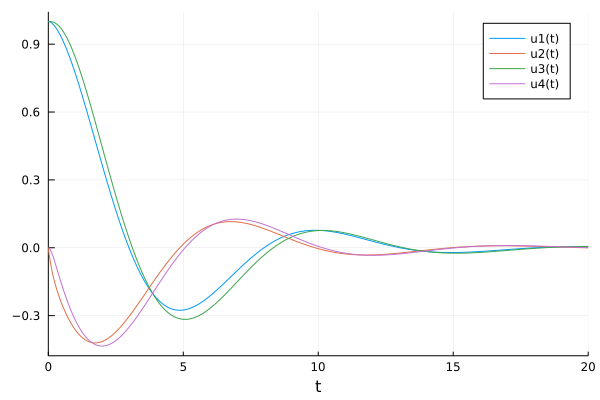

In [7]:
# Convert into ODE form:
data = ODEProblem(net_machine, u_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)

To check whether the 2nd state is being transferred correctly, we can adjust the relevant coefficient and see what effect it has. As can be seen from the following plot, the damping had a major effect on the behavior. This indicates that the 2nd state was succefully transfered.

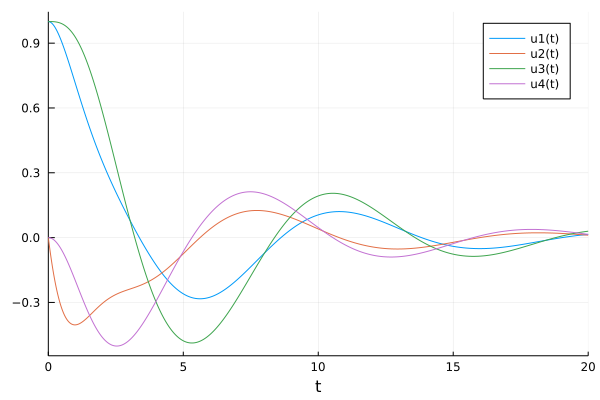

In [8]:
# Coefficient
c2 = 0.5; # Lower damping

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)

### Part 2 - Three boxes

Consider a more complicate case with more boxes and more state variables. Instead of dealing with a single output per box, let us expand this to two outputs and see how the readout and state functions must change.

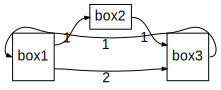

In [9]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [:1], [:1, :2]) );
box2 = add_box!( diagram, Box(:box2, [:1], [:1]) );
box3 = add_box!( diagram, Box(:box3, [:1, :2], [:1]) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1)  
    (box1,2) => (box3,2) 
    (box2,1) => (box3,1)
    (box3,1) => (box1,1)    
])

show_diagram(diagram)

Like before, we make a set of external variables to store the state of each box. However, we must take care in how the state functions are constructed to ensure the input vector is overwritten with the right variables. The wiring diagram acts as a guide for what variables must be chosen and in what order they are received.

In [10]:
#- Readout functions: r(u)
s1 = zeros(2);
s2 = zeros(2);
s3 = zeros(2);

function readout1(u) 
    global s1 = u;
    return [0, 0];    # Number of wire outputs: The box has two outputs so the output must have length 2.
end

function readout2(u)
    global s2 = u;
    return [0];
end

function readout3(u)
    global s3 = u;
    return [0];
end

#- Input Functions: 
function equation1(u, x, p, t) 
    x = s3;        # Box1 receives the state of box3
    return [ u[2], -k1*(u[1] - x[1]) - c1*(u[2] - x[2]) ]; 
end

function equation2(u, x, p, t) 
    x = s1;        # Box2 receives the state of box1
    return [ u[2], -k2*( u[1] - x[1] ) - c2*( u[2] - x[2] ) ]; 
end

# Note: Do not add a comma between vectors.
function equation3(u, x, p, t) 
    x = [s2 s1];   # Box3 receives the state of box2, then the state of box 1 - order matters.
    return [ u[2], -k2*( u[1] - x[1] + x[3] ) - c2*( u[2] - x[2] + x[4] ) ]; 
end

equation3 (generic function with 1 method)

The inputs and outputs of the machines are only determined by the wires coming in and out of a box. The number of states are determined the length of each state. These two are independent of each other as the state can be very large and the number of outputs very small.

In [11]:
# Machines:
                                # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float64}( 1, 2, 2, equation1, readout1 );    
box2_machine = ContinuousMachine{Float64}( 1, 2, 1, equation2, readout2 );  
box3_machine = ContinuousMachine{Float64}( 2, 2, 1, equation3, readout3 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine, box3_machine]);

This system compiles succesfully and all the data appears to be transferred succesfully. In total there are six state variables that dictate the behavior of the system. This could be easily increased by modifying the equations and the wiring diagram would not need to be altered. Evidently this is a very flexible work-around.

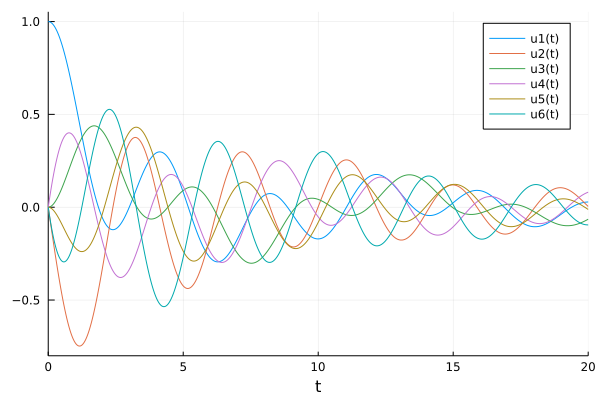

In [12]:
# Initial conditions:
u_init = [1, 0, 0, 0, 0, 0];

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)